<a href="https://colab.research.google.com/github/lauranonce11/Progetto-Python/blob/main/Analisi_discorsi_politici_con_DeBERTa_e_implicazione_logica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Il mio codice usa come dataset 8 discorsi pubblici di presidenti estratti da siti governativi e si pone come principale task quella di confrontare le coppie dei discorsi che appartengono alla stessa macroarea geografica misurando la posizione rispetto ad alcune frasi predefinite.***

***Si tratta di discorsi che hanno come argomento principale il terrorismo islamico, motivo per cui le frasi predefinite saranno alcune di impronta più diplomatica altre maggiormente radicali.***

***EUROPA DELL'OVEST***

**FRANCIA: discorso di Hollande a seguito degli attentati terroristici del 13 e 14 novembre del 2015.**

Questo blocco di codice esegue varie operazioni di elaborazione del linguaggio naturale (NLP) su un dataset.

In questa prima parte di codice non faccio altro che normalizzare il testo, ovvero renderlo idoneo ad essere manipolato. Suddivido il dataset in due fasi "test" e "validation", ma lo faccio esclusivamente per comodità in maniera tale da avere due valori che possono essere confrontati tra di loro e poi un punteggio medio che riassuma tutti i risultati.
Divido il dataset in frasi ed estraggo da tali frasi diverse entità, specificamente: persone, per vedere quali e quanti politici vengono nominati, organizzazioni, luoghi, date ed eventi, in maniera tale da rendere i discorsi più facilmente accessibili nelle loro componenti principali.

In [ ]:
!pip install sentence-transformers
!pip install scikit-learn
!pip install deberta
!pip install transformers
#Lo script inizia importando varie librerie
import json #per caricare e salvare dati in formato JSON
import pandas as pd #per la manipolazione e l'analisi dei dati con DataFrame
import spacy #una libreria NLP per l'elaborazione del linguaggio naturale
import torch #per l'uso del framework PyTorch, utilizzato per il machine learning
from transformers import DebertaForSequenceClassification, DebertaTokenizer #per caricare modelli pre-addestrati della libreria Hugging Face
#AutoTokenizer: per caricare tokenizzatori pre-addestrati
#DebertaForSequenceClassification: modello DeBERTa per la classificazione delle sequenze
#DebertaTokenizer: tokenizzatore specifico per il modello DeBERTa
from sentence_transformers import SentenceTransformer, util #per lavorare con modelli Sentence-BERT

nlp = spacy.load("en_core_web_sm") #carica il modello SpaCy "en_core_web_sm" per l'elaborazione del linguaggio naturale in inglese

with open('datasetFrancia.json', 'r') as file: #apre il file JSON in modalità lettura
    dataset = json.load(file) #carica i dati JSON dal file e li converte in un oggetto Python (dizionario)

validation_data = pd.DataFrame(dataset["validation"]) #crea un DataFrame per i dati di validazione
test_data = pd.DataFrame(dataset["test"]) #crea un DataFrame per i dati di test
combined_data = pd.concat([validation_data, test_data]) #combina i DataFrame di validazione e test in un unico DataFrame

print(validation_data)
print(test_data)

#La funzione preprocess_text prende un input di testo e utilizza SpaCy per elaborarlo.
def preprocess_text(text):
    doc = nlp(text) #elabora il testo utilizzando il modello SpaCy caricato
    return [sent.text for sent in doc.sents] #estrae e restituisce le frasi dal documento elaborato

sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2') #carica il modello Sentence-BERT pre-addestrato "all-MiniLM-L6-v2"

test_sentences = [sentence for content in test_data["content"].tolist() for sentence in preprocess_text(content)] #converte la colonna "content" del DataFrame di test in una lista e pre-processa il contenuto, dividendolo in frasi
validation_sentences = [sentence for content in validation_data["content"].tolist() for sentence in preprocess_text(content)]
combined_sentences = test_sentences + validation_sentences #combina le frasi di test e validazione in una lista unica

print("Le frasi del dataset sono:", combined_sentences)
print("Le frasi della fase di test del modello sono:", test_sentences)
print("Le frasi della fase di validazione del modello sono:", validation_sentences)

doc = nlp(" ".join(combined_data["content"].tolist())) #elabora il testo combinato utilizzando SpaCy e unendo in un'unica stringa la lista dei content
politici = [ent.text for ent in doc.ents if ent.label_ == "PERSON"] #estrae tutte le entità di tipo "PERSON"
organizzazioni = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
luoghi = [ent.text for ent in doc.ents if ent.label_ == "GPE"]
date = [ent.text for ent in doc.ents if ent.label_ == "DATE"]
eventi = [ent.text for ent in doc.ents if ent.label_ == "EVENT"]

print("Le persone menzionate sono:", politici)
print("Le organizzazioni rilevanti sono:", organizzazioni)
print("I luoghi rilevanti sono:", luoghi)
print("Le date significative:", date)
print("Gli eventi significativi sono:", eventi)

  Using cached DeBERTa-0.1.12-py3-none-any.whl.metadata (15 kB)
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
    id                                            content
0   10  The enemy uses the vilest means in its attempt...
1   28  But I am aware that I must take measures at ho...
2   30  But we must act in accordance with the constit...
3   14  I also want to pay tribute to the security for...
4    9  In this war, which began some years ago, we ar...
5    3  They were carried out by a jihadist army, by 

Questa parte di codice calcola la similarità tra le frasi predefinite e le frasi del dataset utilizzando il modello Sentence-BERT.

In questa seconda parte di codice definisco delle frasi prefissate che costituiranno il termine di paragone per le mie analisi. in questo caso specifico, misuro la similarità tra le 4 frasi predefinite e tutte le frasi del dataset, stampando a video non solo i singoli risultati, ma mostrando quale frase del testo è rispettivamente la più simile ad ognuna di quelle prefissat.

In [ ]:
prefixed_sentences = [
    "Islamic terrorism is a threat to global security.",
    "There can be no compromise with terrorists.",
    "We must not intervene militarily in the Middle East.",
    "We must understand the differences between the Islamic faith and terrorism."
] #La lista prefixed_sentences contiene quattro frasi predefinite che verranno utilizzate per il confronto con le frasi del dataset.

print("Le frasi prefissate sono:")
for prefixed_sentence in prefixed_sentences:
    print(prefixed_sentence)

sentences_embeddings = sentence_transformer.encode(combined_sentences) #genera gli embedding per tutte le frasi combinate utilizzando il modello Sentence-BERT

prefixed_sentences_embeddings = sentence_transformer.encode(prefixed_sentences) #genera gli embedding per le frasi prefissate utilizzando il modello Sentence-BERT

#Il codice utilizza due cicli for per iterare su ogni coppia di frasi prefissate e frasi del dataset
print("Similarità tra le frasi prefissate e le frasi del dataset")
for i, combined_sentence in enumerate(combined_sentences): #itera su ogni frase del dataset e assegna l'indice i e la frase combined_sentence alla variabile
    for j, prefixed_sentence in enumerate(prefixed_sentences): #itera su ogni frase prefissata e assegna l'indice j e la frase prefixed_sentence alla variabile
        similarity = util.pytorch_cos_sim(sentences_embeddings[i], prefixed_sentences_embeddings[j]) #Per ogni coppia di frasi, il codice calcola la similarità coseno tra l'embedding della frase del dataset e l'embedding della frase prefissata utilizzando la funzione util.pytorch_cos_sim
        print(f"La similarità tra '{prefixed_sentence}' e '{combined_sentence}' è: {similarity.item():.4f}") #Il codice stampa la similarità tra la frase prefissata e la frase del dataset utilizzando una f-string

most_similar_sentences = [] #inizializza una lista vuota che conterrà le frasi più simili per ogni frase prefissata
for j, prefixed_sentence in enumerate(prefixed_sentences): #utilizza un ciclo for per iterare su ogni frase prefissata
    max_similarity = 0 #inizializza la similarità massima a 0
    most_similar_sentence = "" #inizializza la frase più simile a una stringa vuota
    for i, combined_sentence in enumerate(combined_sentences): #utilizza un ciclo for per iterare su ogni frase del dataset
        similarity = util.pytorch_cos_sim(sentences_embeddings[i], prefixed_sentences_embeddings[j]) #calcola la similarità coseno tra l'embedding della frase del dataset e l'embedding della frase prefissata utilizzando la funzione util.pytorch_cos_sim
        if similarity.item() > max_similarity: #aggiorna la frase più simile se la similarità corrente è maggiore della massima
            max_similarity = similarity.item() #verifica se la similarità corrente è maggiore della similarità massima
            most_similar_sentence = combined_sentence #aggiorna la frase più simile se la similarità corrente è maggiore della massima
    most_similar_sentences.append(most_similar_sentence) #aggiunge la frase più simile alla lista dei risultati
    print(f"La frase più simile a '{prefixed_sentence}' è: '{most_similar_sentence}', con similarità pari a {max_similarity:.4f}") #stampa la frase più simile per ogni frase prefissata




Le frasi prefissate sono:
Islamic terrorism is a threat to global security.
There can be no compromise with terrorists.
We must not intervene militarily in the Middle East.
We must understand the differences between the Islamic faith and terrorism.
Similarità tra le frasi prefissate e le frasi del dataset
La similarità tra 'Islamic terrorism is a threat to global security.' e 'The acts committed in Paris and near the Stade de France on Friday evening are acts of war.' è: 0.1218
La similarità tra 'There can be no compromise with terrorists.' e 'The acts committed in Paris and near the Stade de France on Friday evening are acts of war.' è: 0.0490
La similarità tra 'We must not intervene militarily in the Middle East.' e 'The acts committed in Paris and near the Stade de France on Friday evening are acts of war.' è: 0.1488
La similarità tra 'We must understand the differences between the Islamic faith and terrorism.' e 'The acts committed in Paris and near the Stade de France on Friday ev

Questa parte di codice calcola il punteggio di entailment tra una serie di premesse e ipotesi utilizzando il modello DeBERTa pre-addestrato per la classificazione delle sequenze.

Come prima, anche qui utilizzo le stesse frasi predefinite, questa volta però per misurare l'entailmente tra le stesse e le frasi del mio dataset. L'entailment non fa altro che verificare l'implicazione logica tra la frase predefinita ela seconda frase, mostrando il punteggio secondo il quale l'ipotesi sarebbe una conseguenza logica della premessa.

Anche in qusto caso stampo a video tutti li entailment scores e anche la frase del discorso che ha il punteggio di entailment maggiore rispetto a ogni singola frase predefinita.

Da notare il fatto che le frasi più simili e quelle con un entailment magiore siano diverse.

Alla fine di questa parte di codice calcolo anche il punteggio di implicazione logica medio.

In [ ]:
from transformers import DebertaForSequenceClassification, DebertaTokenizer

model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-large-mnli') #carica il modello pre-addestrato DeBERTa
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-large-mnli') #carica il tokenizzatore DeBERTa pre-addestrato per la classificazione delle sequenze

def calculate_entailment_score(premise, hypothesis):
    inputs = tokenizer.encode_plus(premise, hypothesis, add_special_tokens=True, max_length=512, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt') #la funzione encode_plus del tokenizzatore DeBERTa prende in input la premessa e l'ipotesi e le converte in un formato adatto per il modello DeBERTa
    outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask']) #esegue il modello DeBERTa sull'input, indicando che deve utilizzare la maschera di attenzione restituita dal tokenizzatore
    logits = outputs.logits #estrae i punteggi di output non normalizzati dal risultato dell'inferenza del modello DeBERTa
    entailment_score = torch.sigmoid(logits[:, 2]).item() #applica la funzione sigmoide ai logits selezionati, ovvero la terza colonna dei logits (entailment), che restituisce un valore compreso tra zero e 1, trasformato poi da item da tensore PyTorch a vettore scalare
    return entailment_score

premises = [
    "Islamic terrorism is a threat to global security.",
    "There can be no compromise with terrorists.",
    "We must not intervene militarily in the Middle East.",
    "We must understand the differences between the Islamic faith and terrorism."
]

hypotheses_test = test_sentences
hypotheses_validation = validation_sentences

def calculate_entailment_scores(sentences, premises): #questa funzione calcola i punteggi di entailment tra ogni frase in un elenco di frasi e ogni premessa in un elenco di premesse
    entailment_scores = [] #Inizializza una lista vuota entailment_scores che conterrà i punteggi di entailment calcolati
    for sentence in sentences: #itera su ogni frase in sentences
        for premise in premises: #itera su ogni premessa in premises
            entailment_score = calculate_entailment_score(premise, sentence) #calcola il punteggio di entailment tra la premessa e la frase
            entailment_scores.append(entailment_score) #aggiunge il punteggio di entailment alla lista entailment_scores
    return entailment_scores

test_entailment_scores = calculate_entailment_scores(test_sentences, premises) #calcola i punteggi di entailment tra le frasi di test e le premesse
validation_entailment_scores = calculate_entailment_scores(validation_sentences, premises) #calcola i punteggi di entailment tra le frasi di validazione e le premesse

print("Test entailment scores:", test_entailment_scores)
print("Validation entailment scores:", validation_entailment_scores)

test_avg_entailment_score = sum(test_entailment_scores) / len(test_entailment_scores) #calcola il punteggio medio di entailment delle frasi di test, sommando i punteggi di entailment e dividendo per il numero di elementi della lista
validation_avg_entailment_score = sum(validation_entailment_scores) / len(validation_entailment_scores) #calcola il punteggio medio di entailment delle frasi di validazione

print(f"Test average entailment score: {test_avg_entailment_score:.4f}")
print(f"Validation average entailment score: {validation_avg_entailment_score:.4f}")

highest_entailment_sentences = [] #inizializza una lista vuota per le frasi con il punteggio di entailment più alto per ogni premessa
for premise in premises: #Itera su ogni premessa nell'elenco
    max_entailment_score = 0 #inizializza il punteggio di entailment massimo a 0
    highest_entailment_sentence = "" #inizializza la frase con il punteggio di entailment più alto a una stringa vuota
    for hypothesis in combined_sentences: #itera su ogni ipotesi in combined_sentences
        entailment_score = calculate_entailment_score(premise, hypothesis) #calcola il punteggio di entailment tra la premessa e l'ipotesi
        if entailment_score > max_entailment_score: #aggiorna il punteggio di entailment massimo e la frase corrispondente se il punteggio corrente è maggiore del massimo
            max_entailment_score = entailment_score
            highest_entailment_sentence = hypothesis
    highest_entailment_sentences.append(highest_entailment_sentence) #aggiunge la frase con il punteggio di entailment più alto alla lista
    print(f"La frase con il più alto punteggio di entailment per '{premise}' è '{highest_entailment_sentence}' con un punteggio pari a {max_entailment_score:.4f}") #stampa una stringa che indica la frase con il punteggio di entailment più alto per la premessa corrente, insieme al suo punteggio di entailment


Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test entailment scores: [0.04395810142159462, 0.18691062927246094, 0.046782251447439194, 0.031072108075022697, 0.03975514695048332, 0.0430501364171505, 0.024609064683318138, 0.02937019243836403, 0.030947230756282806, 0.1589912623167038, 0.05381464585661888, 0.0623459592461586, 0.06317919492721558, 0.057970430701971054, 0.04595019295811653, 0.04304555058479309, 0.0862487331032753, 0.029502922669053078, 0.07897276431322098, 0.06603086739778519, 0.10571051388978958, 0.1470533311367035, 0.1833602339029312, 0.10529163479804993, 0.021789660677313805, 0.019625293090939522, 0.05619639903306961, 0.04259840026497841, 0.13757118582725525, 0.2607688009738922, 0.37369874119758606, 0.3539261817932129, 0.10689646005630493, 0.09120602905750275, 0.05229892581701279, 0.040986113250255585, 0.04335734248161316, 0.07581483572721481, 0.05625710263848305, 0.09563018381595612, 0.05790962278842926, 0.06565147638320923, 0.06282839179039001, 0.052043091505765915, 0.05125321447849274, 0.07097084075212479, 0.15024

In questa ultima parte di codice non faccio altro che stampare tramite grafico a dispersione l'entailment score di ogni frasi, vedendo così le differenze tra ciascuna di esse.

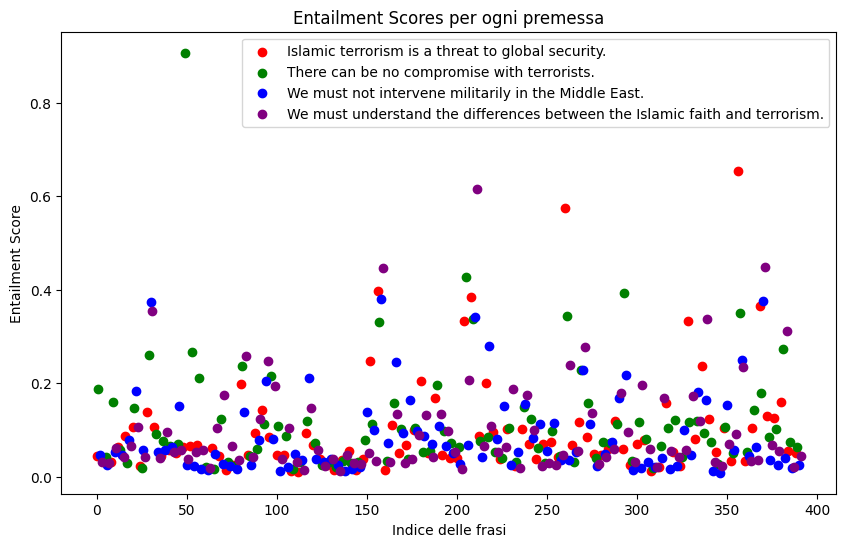

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import util

combined_entailment_scores = test_entailment_scores + validation_entailment_scores
entailment_df = pd.DataFrame({
    'Premesse': premises * len(combined_sentences),
    'Ipotesi': combined_sentences * len(premises),
    'Entailment Score': combined_entailment_scores
})

plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'purple']
x_values = range(len(entailment_df))

for i, premise in enumerate(premises):
    scores = entailment_df[entailment_df['Premesse'] == premise]['Entailment Score']
    plt.scatter([x_values[j] for j in entailment_df.index if entailment_df.iloc[j]['Premesse'] == premise], scores, c=colors[i % len(colors)], label=premise)

plt.xlabel('Indice delle frasi')
plt.ylabel('Entailment Score')
plt.title('Entailment Scores per ogni premessa')
plt.legend()
plt.show()




**Inghilterra: discorso di Theresa May a seguito degli attentati terroristici di Manchester del 2017.**

In [ ]:
nlp = spacy.load("en_core_web_sm")

with open('datasetInghilterra.json', 'r') as file:
    dataset = json.load(file)

validation_data = pd.DataFrame(dataset["validation"])
test_data = pd.DataFrame(dataset["test"])
combined_data = pd.concat([validation_data, test_data])

print(validation_data)
print(test_data)

def preprocess_text(text):
    doc = nlp(text)
    return [sent.text for sent in doc.sents]

sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

test_sentences = [sentence for content in test_data["content"].tolist() for sentence in preprocess_text(content)]
validation_sentences = [sentence for content in validation_data["content"].tolist() for sentence in preprocess_text(content)]
combined_sentences = test_sentences + validation_sentences

print("Le frasi del dataset sono:", combined_sentences)
print("Le frasi della fase di test del modello sono:", test_sentences)
print("Le frasi della fase di validazione del modello sono:", validation_sentences)

doc = nlp(" ".join(combined_data["content"].tolist()))
politici = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
organizzazioni = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
luoghi = [ent.text for ent in doc.ents if ent.label_ == "GPE"]
date = [ent.text for ent in doc.ents if ent.label_ == "DATE"]
eventi = [ent.text for ent in doc.ents if ent.label_ == "EVENT"]

print("Le persone menzionate sono:", politici)
print("Le organizzazioni rilevanti sono:", organizzazioni)
print("I luoghi rilevanti sono:", luoghi)
print("Le date significative:", date)
print("Gli eventi significativi sono:", eventi)

    id                                            content
0   17  Significant resources have been deployed to th...
1   24  At terrible moments like these it is customary...
2   29  Of the men and women of the emergency services...
3   18  For people who live and work in Manchester, th...
4    3  It is now beyond doubt that the people of Manc...
5   20  So please think of those people who are experi...
6   31  For they are the images that embody the spirit...
7   34  And today, let us remember those who died and ...
8   33  And we all, every single one of us, stand with...
9    9  All acts of terrorism are cowardly attacks on ...
10  21  The threat level remains at severe. That means...
11  13  The police and security services believe that ...
12  14  The police and security services believe they ...
13  10  As things stand, I can tell you that in additi...
14  27  And in the days ahead, those must be the thing...
15  15  The police and emergency services have, as alw...
16  23  And, a

In [ ]:
prefixed_sentences = [
    "Islamic terrorism is a threat to global security.",
    "There can be no compromise with terrorists.",
    "We must not intervene militarily in the Middle East.",
    "We must understand the differences between the Islamic faith and terrorism."
]

print("Le frasi prefissate sono:")
for prefixed_sentence in prefixed_sentences:
    print(prefixed_sentence)

sentences_embeddings = sentence_transformer.encode(combined_sentences)

prefixed_sentences_embeddings = sentence_transformer.encode(prefixed_sentences)

print("Similarità tra le frasi prefissate e le frasi del dataset")
for i, combined_sentence in enumerate(combined_sentences):
    for j, prefixed_sentence in enumerate(prefixed_sentences):
        similarity = util.pytorch_cos_sim(sentences_embeddings[i], prefixed_sentences_embeddings[j])
        print(f"La similarità tra '{prefixed_sentence}' e '{combined_sentence}' è: {similarity.item():.4f}")

most_similar_sentences = []
for j, prefixed_sentence in enumerate(prefixed_sentences):
    max_similarity = 0
    most_similar_sentence = ""
    for i, combined_sentence in enumerate(combined_sentences):
        similarity = util.pytorch_cos_sim(sentences_embeddings[i], prefixed_sentences_embeddings[j])
        if similarity.item() > max_similarity:
            max_similarity = similarity.item()
            most_similar_sentence = combined_sentence
    most_similar_sentences.append(most_similar_sentence)
    print(f"La frase più simile a '{prefixed_sentence}' è: '{most_similar_sentence}', con similarità pari a {max_similarity:.4f}")

Le frasi prefissate sono:
Islamic terrorism is a threat to global security.
There can be no compromise with terrorists.
We must not intervene militarily in the Middle East.
We must understand the differences between the Islamic faith and terrorism.
Similarità tra le frasi prefissate e le frasi del dataset
La similarità tra 'Islamic terrorism is a threat to global security.' e 'We know that many friends and relatives of people caught up in the attack are still trying to find out what has happened to their children, brothers and sisters, parents, and loved ones.' è: 0.2590
La similarità tra 'There can be no compromise with terrorists.' e 'We know that many friends and relatives of people caught up in the attack are still trying to find out what has happened to their children, brothers and sisters, parents, and loved ones.' è: 0.1445
La similarità tra 'We must not intervene militarily in the Middle East.' e 'We know that many friends and relatives of people caught up in the attack are sti

In [ ]:
model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-large-mnli')
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-large-mnli')

def calculate_entailment_score(premise, hypothesis):
    inputs = tokenizer.encode_plus(premise, hypothesis, add_special_tokens=True, max_length=512, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt')
    outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
    logits = outputs.logits
    entailment_score = torch.sigmoid(logits[:, 2]).item()
    return entailment_score

premises = [
    "Islamic terrorism is a threat to global security.",
    "There can be no compromise with terrorists.",
    "We must not intervene militarily in the Middle East.",
    "We must understand the differences between the Islamic faith and terrorism."
]

hypotheses_test = test_sentences
hypotheses_validation = validation_sentences

def calculate_entailment_scores(sentences, premises):
    entailment_scores = []
    for sentence in sentences:
        for premise in premises:
            entailment_score = calculate_entailment_score(premise, sentence)
            entailment_scores.append(entailment_score)
    return entailment_scores

test_entailment_scores = calculate_entailment_scores(test_sentences, premises)
validation_entailment_scores = calculate_entailment_scores(validation_sentences, premises)

print("Test entailment scores:", test_entailment_scores)
print("Validation entailment scores:", validation_entailment_scores)

test_avg_entailment_score1 = sum(test_entailment_scores) / len(test_entailment_scores)
validation_avg_entailment_score1 = sum(validation_entailment_scores) / len(validation_entailment_scores)

print(f"Test average entailment score: {test_avg_entailment_score1:.4f}")
print(f"Validation average entailment score: {validation_avg_entailment_score1:.4f}")

highest_entailment_sentences = []
for premise in premises:
    max_entailment_score = 0
    highest_entailment_sentence = ""
    for hypothesis in combined_sentences:
        entailment_score = calculate_entailment_score(premise, hypothesis)
        if entailment_score > max_entailment_score:
            max_entailment_score = entailment_score
            highest_entailment_sentence = hypothesis
    highest_entailment_sentences.append(highest_entailment_sentence)
    print(f"La frase con il più alto punteggio di entailment per '{premise}' è '{highest_entailment_sentence}' con un punteggio pari a {max_entailment_score:.4f}")

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test entailment scores: [0.12204685062170029, 0.21649174392223358, 0.26197248697280884, 0.17026719450950623, 0.17003653943538666, 0.21465787291526794, 0.2972427308559418, 0.18931032717227936, 0.09513513743877411, 0.06421134620904922, 0.05410664156079292, 0.09231527894735336, 0.13281790912151337, 0.04833240807056427, 0.3672284781932831, 0.1775399148464203, 0.011681427247822285, 0.018201831728219986, 0.04984738305211067, 0.017926963046193123, 0.19454501569271088, 0.13612894713878632, 0.18265016376972198, 0.20127913355827332, 0.10347896069288254, 0.04271223396062851, 0.08016685396432877, 0.032338034361600876, 0.23921234905719757, 0.33827656507492065, 0.4217067360877991, 0.24534972012043, 0.17993098497390747, 0.2025230973958969, 0.26902785897254944, 0.16895227134227753, 0.08554110676050186, 0.05868253484368324, 0.2250814139842987, 0.05416392907500267, 0.11292743682861328, 0.09049419313669205, 0.22932149469852448, 0.08264850825071335, 0.12828761339187622, 0.19205008447170258, 0.256960839033

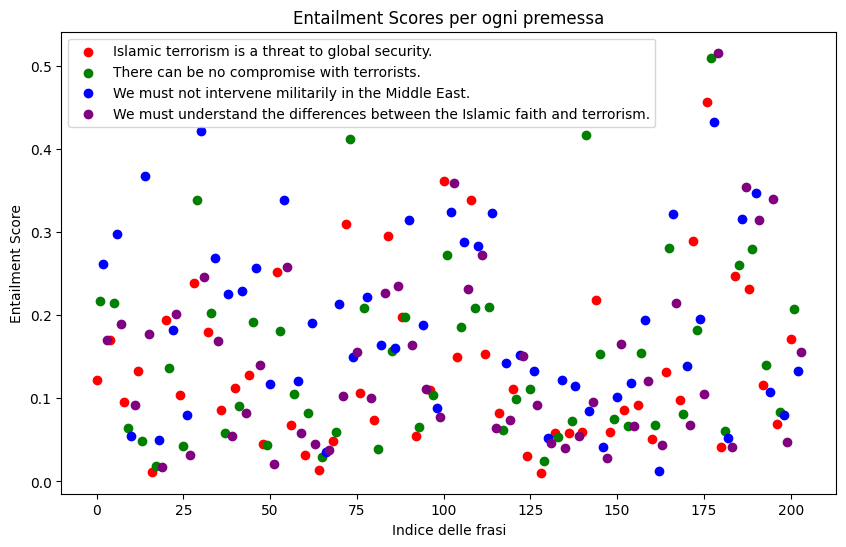

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import util

combined_entailment_scores = test_entailment_scores + validation_entailment_scores
entailment_df = pd.DataFrame({
    'Premesse': premises * len(combined_sentences),
    'Ipotesi': combined_sentences * len(premises),
    'Entailment Score': combined_entailment_scores
})

plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'purple']
x_values = range(len(entailment_df))

for i, premise in enumerate(premises):
    scores = entailment_df[entailment_df['Premesse'] == premise]['Entailment Score']
    plt.scatter([x_values[j] for j in entailment_df.index if entailment_df.iloc[j]['Premesse'] == premise], scores, c=colors[i % len(colors)], label=premise)

plt.xlabel('Indice delle frasi')
plt.ylabel('Entailment Score')
plt.title('Entailment Scores per ogni premessa')
plt.legend()
plt.show()

In questo blocco di codice creo un grafico a barre per confrontare l'Entailment Score dei due dataset, quello della Francia e quello dell'Inghilterra.

Alla fine di ogni coppia di discorsi, ovvero per ogni area geografica, creo un grafico  a barre per confrontare l'entailment score delle due nazioni. In questo caso vediamo come il discorso di Theresa May abbia un punteggio di implicazione logica medio maggiore rispetto a quello del discorso di Hollande, considerando ovviamente sempre le frasi predefinite. Più alte sono le barre del grafico, maggiore è l'entailment score.

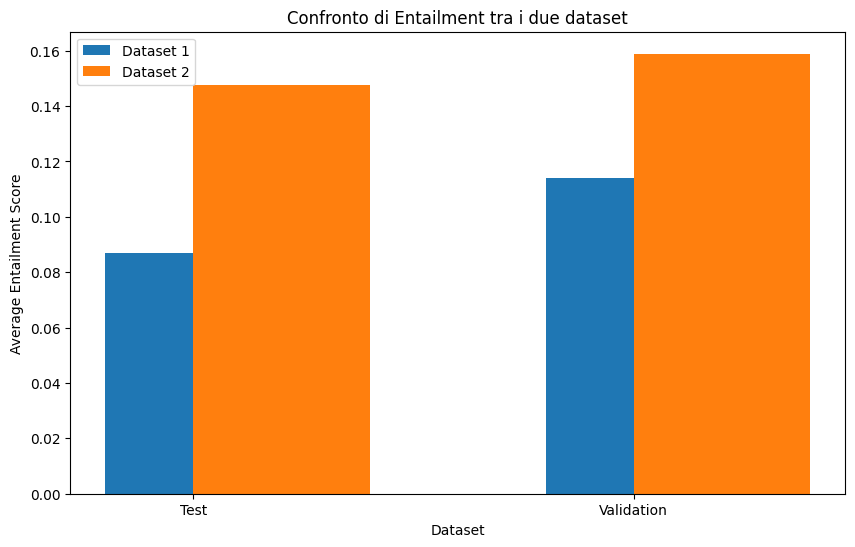

In [ ]:

labels = ['Test', 'Validation'] #Definisce le label per l'asse x del grafico. In questo caso, le etichette sono "Test" e "Validation", che corrispondono ai dataset della fase di test e validation.
scores1 = [test_avg_entailment_score, validation_avg_entailment_score] #Definisce i punteggi medi di entailment per il primo dataset. I punteggi vengono inseriti in una lista, dove il primo elemento è il punteggio di entailment per il dataset della fase di test e il secondo elemento è il punteggio di entailment per il dataset della fse di validation.
scores2 = [test_avg_entailment_score1, validation_avg_entailment_score1]

x = range(len(labels)) #Crea un range di numeri compreso tra 0 e il numero di etichette. Questo intervallo verrà utilizzato come coordinata x per le barre nel grafico.

plt.figure(figsize=(10, 6)) #Imposta la dimensione del grafico a 10 x 6.
plt.bar(x, scores1, width=0.4, label='Dataset 1', align='center') #Crea un grafico a barre per il primo dataset. Le coordinate x sono specificate da "x", l'altezza delle barre è specificate da scores1 e la larghezza di ciascuna barra è 0,4. Il parametro "label" viene utilizzato per etichettare le barre nella legenda e il parametro "align" viene utilizzato per centrare le barre sulle coordinate x specificate.
plt.bar(x, scores2, width=0.4, label='Dataset 2', align='edge')
plt.xlabel('Dataset') #Imposta l'asse x come "Dataset".
plt.ylabel('Average Entailment Score') #Imposta l'asse y come "Average Entailment Score".
plt.title('Confronto di Entailment tra i due dataset') #Imposta il titolo del grafico come "Confronto di Entailment tra i due dataset".
plt.xticks(x, labels) #Imposta le label per l'asse x come le label specificate nella lista "labels".
plt.legend() #Aggiunge una legenda al grafico.
plt.show() #Visualizza il grafico

# Nuova sezione

***EUROPA DELL'EST***

**Bulgaria: discorso del 2012 del presidente Plevneliev a seguito dell’attentato di Bourgas del 21 luglio**

In [ ]:
!pip install sentence-transformers
!pip install scikit-learn
!pip install deberta
!pip install transformers

import json
import pandas as pd
import spacy
import torch
from transformers import AutoTokenizer, DebertaForSequenceClassification, DebertaTokenizer
from sentence_transformers import SentenceTransformer, util

nlp = spacy.load("en_core_web_sm")

with open('datasetBulgaria.json', 'r') as file:
    dataset = json.load(file)

validation_data = pd.DataFrame(dataset["validation"])
test_data = pd.DataFrame(dataset["test"])
combined_data = pd.concat([validation_data, test_data])

print(validation_data)
print(test_data)

def preprocess_text(text):
    doc = nlp(text)
    return [sent.text for sent in doc.sents]

sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

test_sentences = [sentence for content in test_data["content"].tolist() for sentence in preprocess_text(content)]
validation_sentences = [sentence for content in validation_data["content"].tolist() for sentence in preprocess_text(content)]
combined_sentences = test_sentences + validation_sentences

print("Le frasi del dataset sono:", combined_sentences)
print("Le frasi della fase di test del modello sono:", test_sentences)
print("Le frasi della fase di validazione del modello sono:", validation_sentences)

doc = nlp(" ".join(combined_data["content"].tolist()))
politici = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
organizzazioni = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
luoghi = [ent.text for ent in doc.ents if ent.label_ == "GPE"]
date = [ent.text for ent in doc.ents if ent.label_ == "DATE"]
eventi = [ent.text for ent in doc.ents if ent.label_ == "EVENT"]

print("Le persone menzionate sono:", politici)
print("Le organizzazioni rilevanti sono:", organizzazioni)
print("I luoghi rilevanti sono:", luoghi)
print("Le date significative:", date)
print("Gli eventi significativi sono:", eventi)

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Le frasi del dataset sono: ['This heritage is a great responsibility that requires us daily and categorically to assert the values of tolerance, to defend democratic values through dialogue and the peaceful co-existence of different communities.', 'Bulgarian society, which is an integral part of European society, is strongly cohesive and insightful and will overcome the consequences of this sinister attack.', 'It has repeatedly demonstrated that it defies ugly provocation.', 'We strongly defend the principles of democracy and will not allow escalation of terrorism, xenophobia, racism, anti-Semitism or other forms of discrimination and inhumanity.', 'Dear friends and relatives of the victims, I express my deepest sympathy for your pain.', 'Great is the pain for you, the people of Israel and Bulgaria, and the entire democratic world.', 'The difficulties make us stronger and more united.', 'Dear friends, Here in the heart of Sofia are houses of worship of different religions, the beautifu

In [ ]:
prefixed_sentences = [
    "Islamic terrorism is a threat to global security.",
    "There can be no compromise with terrorists.",
    "We must not intervene militarily in the Middle East.",
    "We must understand the differences between the Islamic faith and terrorism."
]

print("Le frasi prefissate sono:")
for prefixed_sentence in prefixed_sentences:
    print(prefixed_sentence)

sentences_embeddings = sentence_transformer.encode(combined_sentences)

prefixed_sentences_embeddings = sentence_transformer.encode(prefixed_sentences)

print("Similarità tra le frasi prefissate e le frasi del dataset")
for i, combined_sentence in enumerate(combined_sentences):
    for j, prefixed_sentence in enumerate(prefixed_sentences):
        similarity = util.pytorch_cos_sim(sentences_embeddings[i], prefixed_sentences_embeddings[j])
        print(f"La similarità tra '{prefixed_sentence}' e '{combined_sentence}' è: {similarity.item():.4f}")

most_similar_sentences = []
for j, prefixed_sentence in enumerate(prefixed_sentences):
    max_similarity = 0
    most_similar_sentence = ""
    for i, combined_sentence in enumerate(combined_sentences):
        similarity = util.pytorch_cos_sim(sentences_embeddings[i], prefixed_sentences_embeddings[j])
        if similarity.item() > max_similarity:
            max_similarity = similarity.item()
            most_similar_sentence = combined_sentence
    most_similar_sentences.append(most_similar_sentence)
    print(f"La frase più simile a '{prefixed_sentence}' è: '{most_similar_sentence}', con similarità pari a {max_similarity:.4f}")

Le frasi prefissate sono:
Islamic terrorism is a threat to global security.
There can be no compromise with terrorists.
We must not intervene militarily in the Middle East.
We must understand the differences between the Islamic faith and terrorism.
Similarità tra le frasi prefissate e le frasi del dataset
La similarità tra 'Islamic terrorism is a threat to global security.' e 'This heritage is a great responsibility that requires us daily and categorically to assert the values of tolerance, to defend democratic values through dialogue and the peaceful co-existence of different communities.' è: 0.2651
La similarità tra 'There can be no compromise with terrorists.' e 'This heritage is a great responsibility that requires us daily and categorically to assert the values of tolerance, to defend democratic values through dialogue and the peaceful co-existence of different communities.' è: 0.1965
La similarità tra 'We must not intervene militarily in the Middle East.' e 'This heritage is a gr

In [ ]:
model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-large-mnli')
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-large-mnli')

def calculate_entailment_score(premise, hypothesis):
    inputs = tokenizer.encode_plus(premise, hypothesis, add_special_tokens=True, max_length=512, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt')
    outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
    logits = outputs.logits
    entailment_score = torch.sigmoid(logits[:, 2]).item()
    return entailment_score

premises = [
    "Islamic terrorism is a threat to global security.",
    "There can be no compromise with terrorists.",
    "We must not intervene militarily in the Middle East.",
    "We must understand the differences between the Islamic faith and terrorism."
]

hypotheses_test = test_sentences
hypotheses_validation = validation_sentences

def calculate_entailment_scores(sentences, premises):
    entailment_scores = []
    for sentence in sentences:
        for premise in premises:
            entailment_score = calculate_entailment_score(premise, sentence)
            entailment_scores.append(entailment_score)
    return entailment_scores

test_entailment_scores = calculate_entailment_scores(test_sentences, premises)
validation_entailment_scores = calculate_entailment_scores(validation_sentences, premises)

print("Test entailment scores:", test_entailment_scores)
print("Validation entailment scores:", validation_entailment_scores)

test_avg_entailment_score2 = sum(test_entailment_scores) / len(test_entailment_scores)
validation_avg_entailment_score2 = sum(validation_entailment_scores) / len(validation_entailment_scores)

print(f"Test average entailment score: {test_avg_entailment_score2:.4f}")
print(f"Validation average entailment score: {validation_avg_entailment_score2:.4f}")

highest_entailment_sentences = []
for premise in premises:
    max_entailment_score = 0
    highest_entailment_sentence = ""
    for hypothesis in combined_sentences:
        entailment_score = calculate_entailment_score(premise, hypothesis)
        if entailment_score > max_entailment_score:
            max_entailment_score = entailment_score
            highest_entailment_sentence = hypothesis
    highest_entailment_sentences.append(highest_entailment_sentence)
    print(f"La frase con il più alto punteggio di entailment per '{premise}' è '{highest_entailment_sentence}' con un punteggio pari a {max_entailment_score:.4f}")

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Test entailment scores: [0.15159784257411957, 0.030716391280293465, 0.3362713158130646, 0.08240056037902832, 0.02019702084362507, 0.03081825189292431, 0.2588261067867279, 0.05945802107453346, 0.03368394821882248, 0.046575725078582764, 0.03701358661055565, 0.059384096413850784, 0.07558108866214752, 0.15034832060337067, 0.07572256028652191, 0.09559870511293411, 0.19703061878681183, 0.22171276807785034, 0.36595577001571655, 0.23419322073459625, 0.0297330841422081, 0.03874226659536362, 0.018002042546868324, 0.04283438250422478, 0.029028134420514107, 0.033192459493875504, 0.06330209225416183, 0.023691676557064056, 0.26704493165016174, 0.3482382595539093, 0.34512460231781006, 0.1688632071018219, 0.02344115450978279, 0.06043122336268425, 0.36177197098731995, 0.06960666179656982, 0.21873673796653748, 0.2390233874320984, 0.25842201709747314, 0.16713717579841614]
Validation entailment scores: [0.046430155634880066, 0.10702726989984512, 0.05083833262324333, 0.029111061245203018, 0.138444989919662

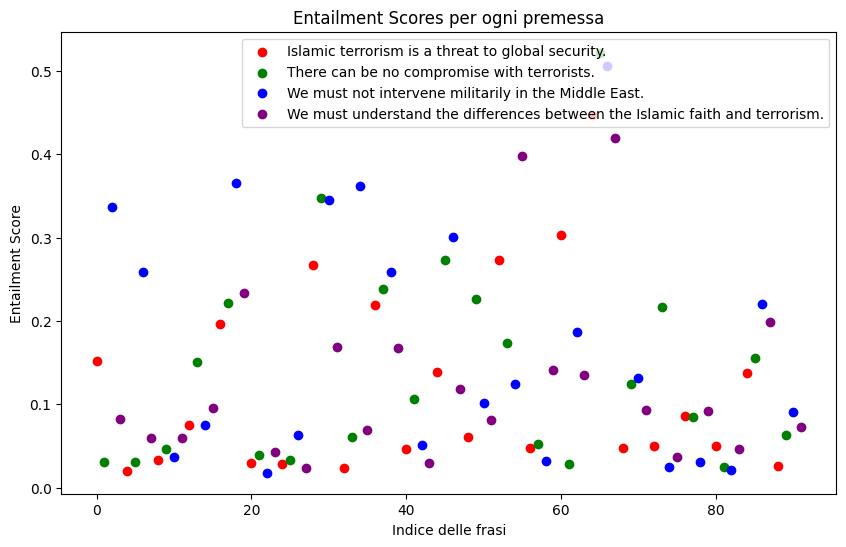

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import util

combined_entailment_scores = test_entailment_scores + validation_entailment_scores
entailment_df = pd.DataFrame({
    'Premesse': premises * len(combined_sentences),
    'Ipotesi': combined_sentences * len(premises),
    'Entailment Score': combined_entailment_scores
})

plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'purple']
x_values = range(len(entailment_df))

for i, premise in enumerate(premises):
    scores = entailment_df[entailment_df['Premesse'] == premise]['Entailment Score']
    plt.scatter([x_values[j] for j in entailment_df.index if entailment_df.iloc[j]['Premesse'] == premise], scores, c=colors[i % len(colors)], label=premise)

plt.xlabel('Indice delle frasi')
plt.ylabel('Entailment Score')
plt.title('Entailment Scores per ogni premessa')
plt.legend()
plt.show()

**TURCHIA: discorso del presidente Erdoğan dopo l'attacco terroristico all'aeroporto Atatürk di Istanbul del 28 giugno 2016**

In [ ]:
nlp = spacy.load("en_core_web_sm")

with open('datasetTurchia.json', 'r') as file:
    dataset = json.load(file)

validation_data = pd.DataFrame(dataset["validation"])
test_data = pd.DataFrame(dataset["test"])
combined_data = pd.concat([validation_data, test_data])

print(validation_data)
print(test_data)

def preprocess_text(text):
    doc = nlp(text)
    return [sent.text for sent in doc.sents]

sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

test_sentences = [sentence for content in test_data["content"].tolist() for sentence in preprocess_text(content)]
validation_sentences = [sentence for content in validation_data["content"].tolist() for sentence in preprocess_text(content)]
combined_sentences = test_sentences + validation_sentences

print("Le frasi del dataset sono:", combined_sentences)
print("Le frasi della fase di test del modello sono:", test_sentences)
print("Le frasi della fase di validazione del modello sono:", validation_sentences)

doc = nlp(" ".join(combined_data["content"].tolist()))
politici = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
organizzazioni = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
luoghi = [ent.text for ent in doc.ents if ent.label_ == "GPE"]
date = [ent.text for ent in doc.ents if ent.label_ == "DATE"]
eventi = [ent.text for ent in doc.ents if ent.label_ == "EVENT"]

print("Le persone menzionate sono:", politici)
print("Le organizzazioni rilevanti sono:", organizzazioni)
print("I luoghi rilevanti sono:", luoghi)
print("Le date significative:", date)
print("Gli eventi significativi sono:", eventi)

   id                                            content
0   5  I strongly condemn this terrorist attack. I ad...
1   7  I renew my call to all governments of the worl...
2   8  May Allah grant His mercy to those who have lo...
3   3  If states and all humanity do not unite forces...
   id                                            content
0   2  The attack, which has caused the death of many...
1   6  I express my deepest condolences to the famili...
2   1  This attack, which took place during the holy ...
3   4  It is clear that this attack aims to achieve n...
Le frasi del dataset sono: ['The attack, which has caused the death of many innocent people and injured many others, is a cowardly act of terror.', 'I express my deepest condolences to the families of the victims and wish a speedy recovery to the injured.', 'This attack, which took place during the holy month of Ramadan, demonstrates that terrorism strikes without regard for faith and values.', 'It is clear that this attack ai

In [ ]:
prefixed_sentences = [
    "Islamic terrorism is a threat to global security.",
    "There can be no compromise with terrorists.",
    "We must not intervene militarily in the Middle East.",
    "We must understand the differences between the Islamic faith and terrorism."
]

print("Le frasi prefissate sono:")
for prefixed_sentence in prefixed_sentences:
    print(prefixed_sentence)

sentences_embeddings = sentence_transformer.encode(combined_sentences)

prefixed_sentences_embeddings = sentence_transformer.encode(prefixed_sentences)

print("Similarità tra le frasi prefissate e le frasi del dataset")
for i, combined_sentence in enumerate(combined_sentences):
    for j, prefixed_sentence in enumerate(prefixed_sentences):
        similarity = util.pytorch_cos_sim(sentences_embeddings[i], prefixed_sentences_embeddings[j])
        print(f"La similarità tra '{prefixed_sentence}' e '{combined_sentence}' è: {similarity.item():.4f}")

most_similar_sentences = []
for j, prefixed_sentence in enumerate(prefixed_sentences):
    max_similarity = 0
    most_similar_sentence = ""
    for i, combined_sentence in enumerate(combined_sentences):
        similarity = util.pytorch_cos_sim(sentences_embeddings[i], prefixed_sentences_embeddings[j])
        if similarity.item() > max_similarity:
            max_similarity = similarity.item()
            most_similar_sentence = combined_sentence
    most_similar_sentences.append(most_similar_sentence)
    print(f"La frase più simile a '{prefixed_sentence}' è: '{most_similar_sentence}', con similarità pari a {max_similarity:.4f}")

Le frasi prefissate sono:
Islamic terrorism is a threat to global security.
There can be no compromise with terrorists.
We must not intervene militarily in the Middle East.
We must understand the differences between the Islamic faith and terrorism.
Similarità tra le frasi prefissate e le frasi del dataset
La similarità tra 'Islamic terrorism is a threat to global security.' e 'The attack, which has caused the death of many innocent people and injured many others, is a cowardly act of terror.' è: 0.5065
La similarità tra 'There can be no compromise with terrorists.' e 'The attack, which has caused the death of many innocent people and injured many others, is a cowardly act of terror.' è: 0.3491
La similarità tra 'We must not intervene militarily in the Middle East.' e 'The attack, which has caused the death of many innocent people and injured many others, is a cowardly act of terror.' è: 0.3194
La similarità tra 'We must understand the differences between the Islamic faith and terrorism

In [ ]:
model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-large-mnli')
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-large-mnli')

def calculate_entailment_score(premise, hypothesis):
    inputs = tokenizer.encode_plus(premise, hypothesis, add_special_tokens=True, max_length=512, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt')
    outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
    logits = outputs.logits
    entailment_score = torch.sigmoid(logits[:, 2]).item()
    return entailment_score

premises = [
    "Islamic terrorism is a threat to global security.",
    "There can be no compromise with terrorists.",
    "We must not intervene militarily in the Middle East.",
    "We must understand the differences between the Islamic faith and terrorism."
]

hypotheses_test = test_sentences
hypotheses_validation = validation_sentences

def calculate_entailment_scores(sentences, premises):
    entailment_scores = []
    for sentence in sentences:
        for premise in premises:
            entailment_score = calculate_entailment_score(premise, sentence)
            entailment_scores.append(entailment_score)
    return entailment_scores

test_entailment_scores = calculate_entailment_scores(test_sentences, premises)
validation_entailment_scores = calculate_entailment_scores(validation_sentences, premises)

print("Test entailment scores:", test_entailment_scores)
print("Validation entailment scores:", validation_entailment_scores)

test_avg_entailment_score3 = sum(test_entailment_scores) / len(test_entailment_scores)
validation_avg_entailment_score3 = sum(validation_entailment_scores) / len(validation_entailment_scores)

print(f"Test average entailment score: {test_avg_entailment_score3:.4f}")
print(f"Validation average entailment score: {validation_avg_entailment_score3:.4f}")

highest_entailment_sentences = []
for premise in premises:
    max_entailment_score = 0
    highest_entailment_sentence = ""
    for hypothesis in combined_sentences:
        entailment_score = calculate_entailment_score(premise, hypothesis)
        if entailment_score > max_entailment_score:
            max_entailment_score = entailment_score
            highest_entailment_sentence = hypothesis
    highest_entailment_sentences.append(highest_entailment_sentence)
    print(f"La frase con il più alto punteggio di entailment per '{premise}' è '{highest_entailment_sentence}' con un punteggio pari a {max_entailment_score:.4f}")

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test entailment scores: [0.06830380111932755, 0.09108944237232208, 0.11537091434001923, 0.06107049435377121, 0.2101965993642807, 0.23806649446487427, 0.29441797733306885, 0.17953693866729736, 0.029497859999537468, 0.08752009272575378, 0.08566223084926605, 0.03168803080916405, 0.0226134080439806, 0.1200290322303772, 0.0565737746655941, 0.033276915550231934]
Validation entailment scores: [0.20117558538913727, 0.4352923631668091, 0.15393461287021637, 0.10166985541582108, 0.039485085755586624, 0.02270885370671749, 0.14486603438854218, 0.05658358708024025, 0.07752948999404907, 0.03179727494716644, 0.049732353538274765, 0.10204430669546127, 0.12710319459438324, 0.09629777818918228, 0.1701759696006775, 0.07917162775993347, 0.07076624780893326, 0.08291318267583847, 0.01655680313706398, 0.07820728421211243]
Test average entailment score: 0.1078
Validation average entailment score: 0.1069
La frase con il più alto punteggio di entailment per 'Islamic terrorism is a threat to global security.' è '

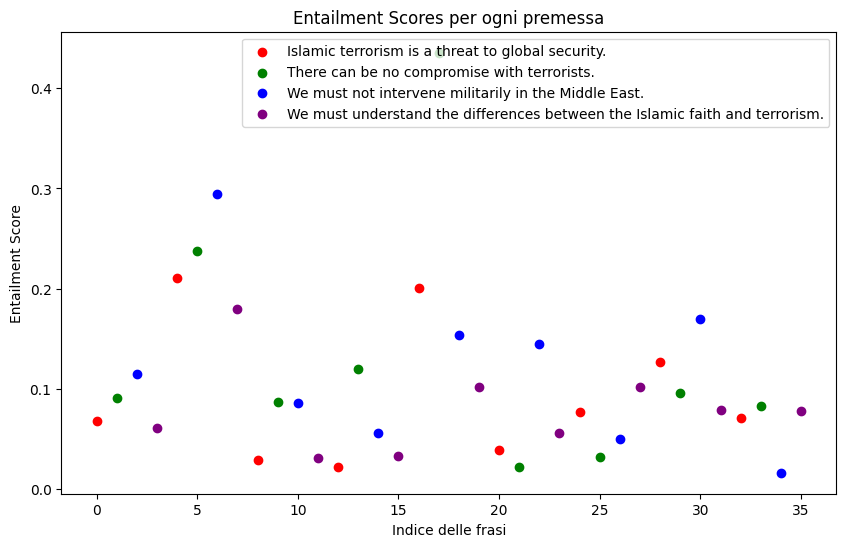

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import util

combined_entailment_scores = test_entailment_scores + validation_entailment_scores
entailment_df = pd.DataFrame({
    'Premesse': premises * len(combined_sentences),
    'Ipotesi': combined_sentences * len(premises),
    'Entailment Score': combined_entailment_scores
})

plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'purple']
x_values = range(len(entailment_df))

for i, premise in enumerate(premises):
    scores = entailment_df[entailment_df['Premesse'] == premise]['Entailment Score']
    plt.scatter([x_values[j] for j in entailment_df.index if entailment_df.iloc[j]['Premesse'] == premise], scores, c=colors[i % len(colors)], label=premise)

plt.xlabel('Indice delle frasi')
plt.ylabel('Entailment Score')
plt.title('Entailment Scores per ogni premessa')
plt.legend()
plt.show()

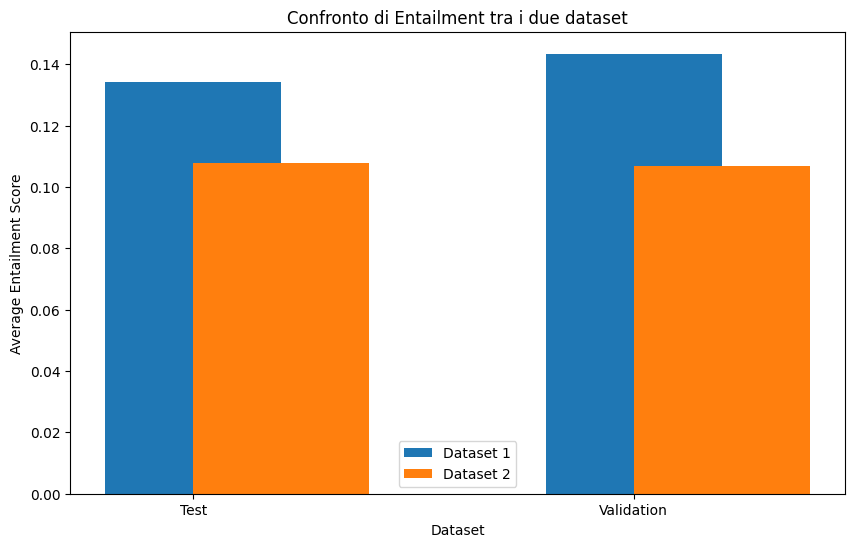

In [ ]:
labels = ['Test', 'Validation']
scores1 = [test_avg_entailment_score2, validation_avg_entailment_score2]
scores2 = [test_avg_entailment_score3, validation_avg_entailment_score3]

x = range(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x, scores1, width=0.4, label='Dataset 1', align='center')
plt.bar(x, scores2, width=0.4, label='Dataset 2', align='edge')
plt.xlabel('Dataset')
plt.ylabel('Average Entailment Score')
plt.title('Confronto di Entailment tra i due dataset')
plt.xticks(x, labels)
plt.legend()
plt.show()

***STATI UNITI***

**AMERICA1: discorso che Obama pronunciò in risposta agli attacchi del 2016**

In [ ]:
!pip install sentence-transformers
!pip install scikit-learn
!pip install deberta
!pip install transformers

import json
import pandas as pd
import spacy
import torch
from transformers import AutoTokenizer, DebertaForSequenceClassification, DebertaTokenizer
from sentence_transformers import SentenceTransformer, util

nlp = spacy.load("en_core_web_sm")

with open('datasetAmerica1.json', 'r') as file:
    dataset = json.load(file)

validation_data = pd.DataFrame(dataset["validation"])
test_data = pd.DataFrame(dataset["test"])
combined_data = pd.concat([validation_data, test_data])

print(validation_data)
print(test_data)

def preprocess_text(text):
    doc = nlp(text)
    return [sent.text for sent in doc.sents]

sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

test_sentences = [sentence for content in test_data["content"].tolist() for sentence in preprocess_text(content)]
validation_sentences = [sentence for content in validation_data["content"].tolist() for sentence in preprocess_text(content)]
combined_sentences = test_sentences + validation_sentences

print("Le frasi del dataset sono:", combined_sentences)
print("Le frasi della fase di test del modello sono:", test_sentences)
print("Le frasi della fase di validazione del modello sono:", validation_sentences)

doc = nlp(" ".join(combined_data["content"].tolist()))
politici = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
organizzazioni = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
luoghi = [ent.text for ent in doc.ents if ent.label_ == "GPE"]
date = [ent.text for ent in doc.ents if ent.label_ == "DATE"]
eventi = [ent.text for ent in doc.ents if ent.label_ == "EVENT"]

print("Le persone menzionate sono:", politici)
print("Le organizzazioni rilevanti sono:", organizzazioni)
print("I luoghi rilevanti sono:", luoghi)
print("Le date significative:", date)
print("Gli eventi significativi sono:", eventi)

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Le frasi del dataset sono: ['This massacre is therefore a further reminder of how easy it is for someone to get their hands on a weapon that lets them shoot people in a school, or in a house of worship, or a movie theater, or in a nightclub.', 'And we have to decide if that is the kind of country we want to be.', 'And to actively do nothing is a decision as well.', 'I just finished a meeting with FBI Director Comey and my homeland security and national security advisors.', 'The FBI is on the scene and leading the investigation, in partnership with local law enforcement.', 'I have directed that the full resources of the federal government be made available for this investigation.', 'As we go together, we will draw inspiration from heroic and selfless acts, friends who helped friends, took care of each other and saved lives.', 'In the face of hate and violence, we will love one another.', 'We will not give in to fear or turn against each other.', 'Instead, we will stand united, as Americ

In [ ]:
prefixed_sentences = [
    "Islamic terrorism is a threat to global security.",
    "There can be no compromise with terrorists.",
    "We must not intervene militarily in the Middle East.",
    "We must understand the differences between the Islamic faith and terrorism."
]

print("Le frasi prefissate sono:")
for prefixed_sentence in prefixed_sentences:
    print(prefixed_sentence)

sentences_embeddings = sentence_transformer.encode(combined_sentences)

prefixed_sentences_embeddings = sentence_transformer.encode(prefixed_sentences)

print("Similarità tra le frasi prefissate e le frasi del dataset")
for i, combined_sentence in enumerate(combined_sentences):
    for j, prefixed_sentence in enumerate(prefixed_sentences):
        similarity = util.pytorch_cos_sim(sentences_embeddings[i], prefixed_sentences_embeddings[j])
        print(f"La similarità tra '{prefixed_sentence}' e '{combined_sentence}' è: {similarity.item():.4f}")

most_similar_sentences = []
for j, prefixed_sentence in enumerate(prefixed_sentences):
    max_similarity = 0
    most_similar_sentence = ""
    for i, combined_sentence in enumerate(combined_sentences):
        similarity = util.pytorch_cos_sim(sentences_embeddings[i], prefixed_sentences_embeddings[j])
        if similarity.item() > max_similarity:
            max_similarity = similarity.item()
            most_similar_sentence = combined_sentence
    most_similar_sentences.append(most_similar_sentence)
    print(f"La frase più simile a '{prefixed_sentence}' è: '{most_similar_sentence}', con similarità pari a {max_similarity:.4f}")

Le frasi prefissate sono:
Islamic terrorism is a threat to global security.
There can be no compromise with terrorists.
We must not intervene militarily in the Middle East.
We must understand the differences between the Islamic faith and terrorism.
Similarità tra le frasi prefissate e le frasi del dataset
La similarità tra 'Islamic terrorism is a threat to global security.' e 'This massacre is therefore a further reminder of how easy it is for someone to get their hands on a weapon that lets them shoot people in a school, or in a house of worship, or a movie theater, or in a nightclub.' è: 0.3066
La similarità tra 'There can be no compromise with terrorists.' e 'This massacre is therefore a further reminder of how easy it is for someone to get their hands on a weapon that lets them shoot people in a school, or in a house of worship, or a movie theater, or in a nightclub.' è: 0.1676
La similarità tra 'We must not intervene militarily in the Middle East.' e 'This massacre is therefore a 

In [ ]:
model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-large-mnli')
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-large-mnli')

def calculate_entailment_score(premise, hypothesis):
    inputs = tokenizer.encode_plus(premise, hypothesis, add_special_tokens=True, max_length=512, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt')
    outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
    logits = outputs.logits
    entailment_score = torch.sigmoid(logits[:, 2]).item()
    return entailment_score

premises = [
    "Islamic terrorism is a threat to global security.",
    "There can be no compromise with terrorists.",
    "We must not intervene militarily in the Middle East.",
    "We must understand the differences between the Islamic faith and terrorism."
]

hypotheses_test = test_sentences
hypotheses_validation = validation_sentences

def calculate_entailment_scores(sentences, premises):
    entailment_scores = []
    for sentence in sentences:
        for premise in premises:
            entailment_score = calculate_entailment_score(premise, sentence)
            entailment_scores.append(entailment_score)
    return entailment_scores

test_entailment_scores = calculate_entailment_scores(test_sentences, premises)
validation_entailment_scores = calculate_entailment_scores(validation_sentences, premises)

print("Test entailment scores:", test_entailment_scores)
print("Validation entailment scores:", validation_entailment_scores)

test_avg_entailment_score4 = sum(test_entailment_scores) / len(test_entailment_scores)
validation_avg_entailment_score4 = sum(validation_entailment_scores) / len(validation_entailment_scores)

print(f"Test average entailment score: {test_avg_entailment_score4:.4f}")
print(f"Validation average entailment score: {validation_avg_entailment_score4:.4f}")

highest_entailment_sentences = []
for premise in premises:
    max_entailment_score = 0
    highest_entailment_sentence = ""
    for hypothesis in combined_sentences:
        entailment_score = calculate_entailment_score(premise, hypothesis)
        if entailment_score > max_entailment_score:
            max_entailment_score = entailment_score
            highest_entailment_sentence = hypothesis
    highest_entailment_sentences.append(highest_entailment_sentence)
    print(f"La frase con il più alto punteggio di entailment per '{premise}' è '{highest_entailment_sentence}' con un punteggio pari a {max_entailment_score:.4f}")


config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Test entailment scores: [0.08006077259778976, 0.09862738847732544, 0.08847885578870773, 0.041834909468889236, 0.09864506870508194, 0.09046510607004166, 0.07633250951766968, 0.049548305571079254, 0.06564228236675262, 0.1067795678973198, 0.4548491835594177, 0.06033966690301895, 0.02680819295346737, 0.05258030444383621, 0.11017688363790512, 0.04838690534234047, 0.06246214359998703, 0.1055399477481842, 0.3091040253639221, 0.11338360607624054, 0.04519260674715042, 0.060651253908872604, 0.06317362189292908, 0.028549283742904663, 0.22107090055942535, 0.10842575132846832, 0.18547411262989044, 0.23311707377433777, 0.03616573289036751, 0.036871422082185745, 0.06319534033536911, 0.044297680258750916, 0.020294534042477608, 0.7262042760848999, 0.06557079404592514, 0.06020738184452057, 0.051616232842206955, 0.18724845349788666, 0.016075149178504944, 0.02465124987065792, 0.08005216717720032, 0.05892927572131157, 0.30748412013053894, 0.052573129534721375, 0.021084146574139595, 0.05350014567375183, 0.1

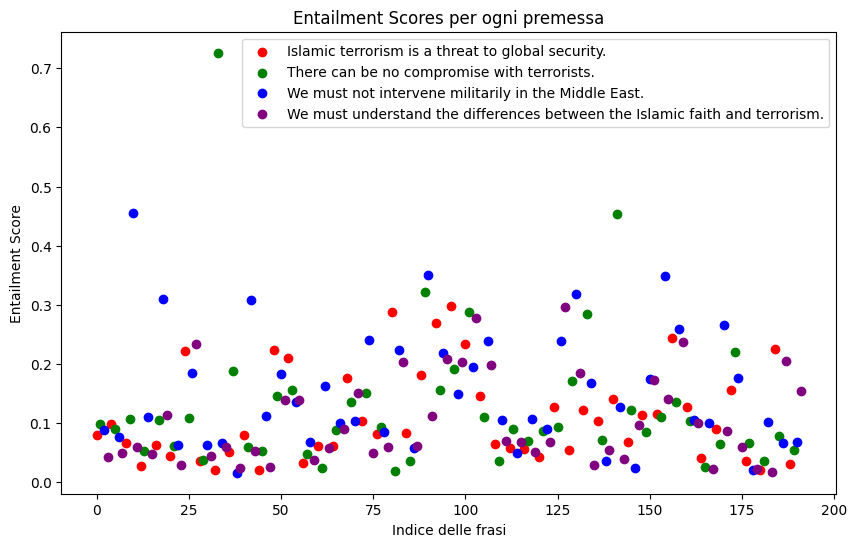

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import util

combined_entailment_scores = test_entailment_scores + validation_entailment_scores
entailment_df = pd.DataFrame({
    'Premesse': premises * len(combined_sentences),
    'Ipotesi': combined_sentences * len(premises),
    'Entailment Score': combined_entailment_scores
})

plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'purple']
x_values = range(len(entailment_df))

for i, premise in enumerate(premises):
    scores = entailment_df[entailment_df['Premesse'] == premise]['Entailment Score']
    plt.scatter([x_values[j] for j in entailment_df.index if entailment_df.iloc[j]['Premesse'] == premise], scores, c=colors[i % len(colors)], label=premise)

plt.xlabel('Indice delle frasi')
plt.ylabel('Entailment Score')
plt.title('Entailment Scores per ogni premessa')
plt.legend()
plt.show()

**America2: discorso del 2017 dove Trump si scaglia contro il terrorismo, preparandosi alla campagna elettorale.**

In [ ]:
!pip install sentence-transformers
!pip install scikit-learn
!pip install deberta
!pip install transformers

import json
import pandas as pd
import spacy
import torch
from transformers import AutoTokenizer, DebertaForSequenceClassification, DebertaTokenizer
from sentence_transformers import SentenceTransformer, util

nlp = spacy.load("en_core_web_sm")

with open('datasetAmerica2.json', 'r') as file:
    dataset = json.load(file)

validation_data = pd.DataFrame(dataset["validation"])
test_data = pd.DataFrame(dataset["test"])
combined_data = pd.concat([validation_data, test_data])

print(validation_data)
print(test_data)

def preprocess_text(text):
    doc = nlp(text)
    return [sent.text for sent in doc.sents]

sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

test_sentences = [sentence for content in test_data["content"].tolist() for sentence in preprocess_text(content)]
validation_sentences = [sentence for content in validation_data["content"].tolist() for sentence in preprocess_text(content)]
combined_sentences = test_sentences + validation_sentences

print("Le frasi del dataset sono:", combined_sentences)
print("Le frasi della fase di test del modello sono:", test_sentences)
print("Le frasi della fase di validazione del modello sono:", validation_sentences)

doc = nlp(" ".join(combined_data["content"].tolist()))
politici = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
organizzazioni = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
luoghi = [ent.text for ent in doc.ents if ent.label_ == "GPE"]
date = [ent.text for ent in doc.ents if ent.label_ == "DATE"]
eventi = [ent.text for ent in doc.ents if ent.label_ == "EVENT"]

print("Le persone menzionate sono:", politici)
print("Le organizzazioni rilevanti sono:", organizzazioni)
print("I luoghi rilevanti sono:", luoghi)
print("Le date significative:", date)
print("Gli eventi significativi sono:", eventi)

  Using cached DeBERTa-0.1.12-py3-none-any.whl.metadata (15 kB)
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
    id                                            content
0   12  Libya is in ruins, our ambassador and three ot...
1   14  At the same time, ISIS is trying to infiltrate...
2   24  I was saying this constantly and to whoever wo...
3   20  It is time for a new approach. Our current str...
4   10  Anyone who cannot name our enemy, is not fit t...
5    6  In March of this year, terrorists detonated a

In [ ]:
prefixed_sentences = [
    "Islamic terrorism is a threat to global security.",
    "There can be no compromise with terrorists.",
    "We must not intervene militarily in the Middle East.",
    "We must understand the differences between the Islamic faith and terrorism."
]

print("Le frasi prefissate sono:")
for prefixed_sentence in prefixed_sentences:
    print(prefixed_sentence)

sentences_embeddings = sentence_transformer.encode(combined_sentences)

prefixed_sentences_embeddings = sentence_transformer.encode(prefixed_sentences)

print("Similarità tra le frasi prefissate e le frasi del dataset")
for i, combined_sentence in enumerate(combined_sentences):
    for j, prefixed_sentence in enumerate(prefixed_sentences):
        similarity = util.pytorch_cos_sim(sentences_embeddings[i], prefixed_sentences_embeddings[j])
        print(f"La similarità tra '{prefixed_sentence}' e '{combined_sentence}' è: {similarity.item():.4f}")

most_similar_sentences = []
for j, prefixed_sentence in enumerate(prefixed_sentences):
    max_similarity = 0
    most_similar_sentence = ""
    for i, combined_sentence in enumerate(combined_sentences):
        similarity = util.pytorch_cos_sim(sentences_embeddings[i], prefixed_sentences_embeddings[j])
        if similarity.item() > max_similarity:
            max_similarity = similarity.item()
            most_similar_sentence = combined_sentence
    most_similar_sentences.append(most_similar_sentence)
    print(f"La frase più simile a '{prefixed_sentence}' è: '{most_similar_sentence}', con similarità pari a {max_similarity:.4f}")

Le frasi prefissate sono:
Islamic terrorism is a threat to global security.
There can be no compromise with terrorists.
We must not intervene militarily in the Middle East.
We must understand the differences between the Islamic faith and terrorism.
Similarità tra le frasi prefissate e le frasi del dataset
La similarità tra 'Islamic terrorism is a threat to global security.' e 'We have enough problems in our country, we do not need another one.' è: 0.1886
La similarità tra 'There can be no compromise with terrorists.' e 'We have enough problems in our country, we do not need another one.' è: 0.2297
La similarità tra 'We must not intervene militarily in the Middle East.' e 'We have enough problems in our country, we do not need another one.' è: 0.2781
La similarità tra 'We must understand the differences between the Islamic faith and terrorism.' e 'We have enough problems in our country, we do not need another one.' è: 0.1304
La similarità tra 'Islamic terrorism is a threat to global sec

In [ ]:
model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-large-mnli')
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-large-mnli')

def calculate_entailment_score(premise, hypothesis):
    inputs = tokenizer.encode_plus(premise, hypothesis, add_special_tokens=True, max_length=512, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt')
    outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
    logits = outputs.logits
    entailment_score = torch.sigmoid(logits[:, 2]).item()
    return entailment_score

premises = [
    "Islamic terrorism is a threat to global security.",
    "There can be no compromise with terrorists.",
    "We must not intervene militarily in the Middle East.",
    "We must understand the differences between the Islamic faith and terrorism."
]

hypotheses_test = test_sentences
hypotheses_validation = validation_sentences

def calculate_entailment_scores(sentences, premises):
    entailment_scores = []
    for sentence in sentences:
        for premise in premises:
            entailment_score = calculate_entailment_score(premise, sentence)
            entailment_scores.append(entailment_score)
    return entailment_scores

test_entailment_scores = calculate_entailment_scores(test_sentences, premises)
validation_entailment_scores = calculate_entailment_scores(validation_sentences, premises)

print("Test entailment scores:", test_entailment_scores)
print("Validation entailment scores:", validation_entailment_scores)

test_avg_entailment_score5 = sum(test_entailment_scores) / len(test_entailment_scores)
validation_avg_entailment_score5 = sum(validation_entailment_scores) / len(validation_entailment_scores)

print(f"Test average entailment score: {test_avg_entailment_score5:.4f}")
print(f"Validation average entailment score: {validation_avg_entailment_score5:.4f}")

highest_entailment_sentences = []
for premise in premises:
    max_entailment_score = 0
    highest_entailment_sentence = ""
    for hypothesis in combined_sentences:
        entailment_score = calculate_entailment_score(premise, hypothesis)
        if entailment_score > max_entailment_score:
            max_entailment_score = entailment_score
            highest_entailment_sentence = hypothesis
    highest_entailment_sentences.append(highest_entailment_sentence)
    print(f"La frase con il più alto punteggio di entailment per '{premise}' è '{highest_entailment_sentence}' con un punteggio pari a {max_entailment_score:.4f}")


Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test entailment scores: [0.040493763983249664, 0.08335646241903305, 0.07865212857723236, 0.0504419282078743, 0.05223090201616287, 0.05737866088747978, 0.1191876232624054, 0.041190724819898605, 0.05887328088283539, 0.07848694175481796, 0.08112496882677078, 0.0731077641248703, 0.041227228939533234, 0.03816891461610794, 0.16092360019683838, 0.06950951367616653, 0.0135843800380826, 0.01011408120393753, 0.20771165192127228, 0.03015885129570961, 0.022346679121255875, 0.020190218463540077, 0.016506318002939224, 0.011600642465054989, 0.024276424199342728, 0.03240864351391792, 0.026397814974188805, 0.021410658955574036, 0.053298693150281906, 0.11108159273862839, 0.1097545176744461, 0.03679560124874115, 0.20979776978492737, 0.48236173391342163, 0.020704491063952446, 0.1399334967136383, 0.05257713049650192, 0.09741372615098953, 0.019965464249253273, 0.028699800372123718, 0.014725680463016033, 0.043380461633205414, 0.010827790945768356, 0.023152850568294525, 0.0882156640291214, 0.3151845335960388,

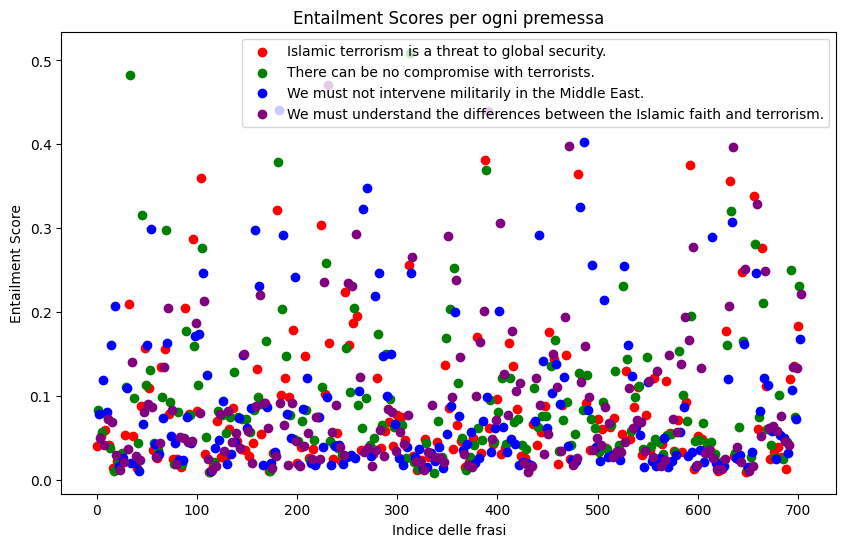

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import util

combined_entailment_scores = test_entailment_scores + validation_entailment_scores
entailment_df = pd.DataFrame({
    'Premesse': premises * len(combined_sentences),
    'Ipotesi': combined_sentences * len(premises),
    'Entailment Score': combined_entailment_scores
})

plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'purple']
x_values = range(len(entailment_df))

for i, premise in enumerate(premises):
    scores = entailment_df[entailment_df['Premesse'] == premise]['Entailment Score']
    plt.scatter([x_values[j] for j in entailment_df.index if entailment_df.iloc[j]['Premesse'] == premise], scores, c=colors[i % len(colors)], label=premise)

plt.xlabel('Indice delle frasi')
plt.ylabel('Entailment Score')
plt.title('Entailment Scores per ogni premessa')
plt.legend()
plt.show()

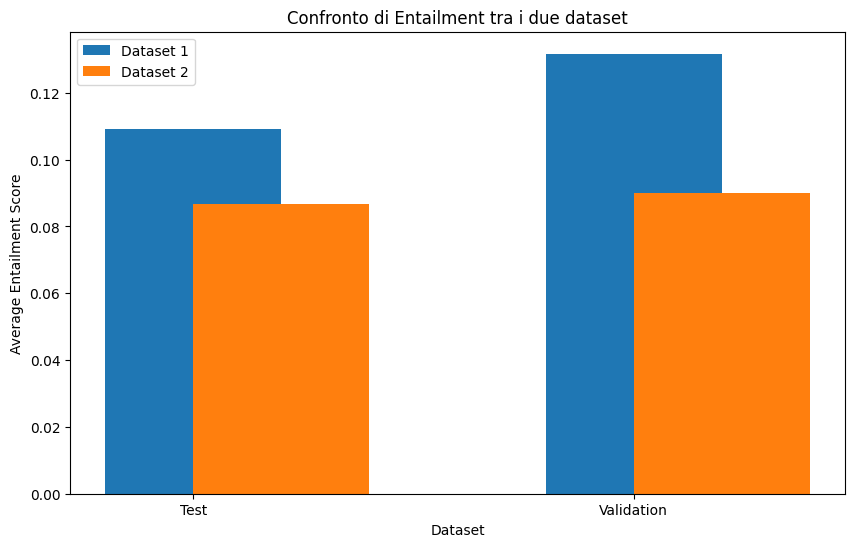

In [ ]:
labels = ['Test', 'Validation']
scores1 = [test_avg_entailment_score4, validation_avg_entailment_score4]
scores2 = [test_avg_entailment_score5, validation_avg_entailment_score5]

x = range(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x, scores1, width=0.4, label='Dataset 1', align='center')
plt.bar(x, scores2, width=0.4, label='Dataset 2', align='edge')
plt.xlabel('Dataset')
plt.ylabel('Average Entailment Score')
plt.title('Confronto di Entailment tra i due dataset')
plt.xticks(x, labels)
plt.legend()
plt.show()

***ASIA***

**CINA: discorso pronunciato da Xi Jinping durante la riunione della Lega Araba del 2016 a cui era stata invitata anche la Cina**

In [ ]:
!pip install sentence-transformers
!pip install scikit-learn
!pip install deberta
!pip install transformers

import json
import pandas as pd
import spacy
import torch
from transformers import AutoTokenizer, DebertaForSequenceClassification, DebertaTokenizer
from sentence_transformers import SentenceTransformer, util

nlp = spacy.load("en_core_web_sm")

with open('datasetCina.json', 'r') as file:
    dataset = json.load(file)

validation_data = pd.DataFrame(dataset["validation"])
test_data = pd.DataFrame(dataset["test"])
combined_data = pd.concat([validation_data, test_data])

print(validation_data)
print(test_data)

def preprocess_text(text):
    doc = nlp(text)
    return [sent.text for sent in doc.sents]

sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

test_sentences = [sentence for content in test_data["content"].tolist() for sentence in preprocess_text(content)]
validation_sentences = [sentence for content in validation_data["content"].tolist() for sentence in preprocess_text(content)]
combined_sentences = test_sentences + validation_sentences

print("Le frasi del dataset sono:", combined_sentences)
print("Le frasi della fase di test del modello sono:", test_sentences)
print("Le frasi della fase di validazione del modello sono:", validation_sentences)

doc = nlp(" ".join(combined_data["content"].tolist()))
politici = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
organizzazioni = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
luoghi = [ent.text for ent in doc.ents if ent.label_ == "GPE"]
date = [ent.text for ent in doc.ents if ent.label_ == "DATE"]
eventi = [ent.text for ent in doc.ents if ent.label_ == "EVENT"]

print("I politici menzionati sono:", politici)
print("Le organizzazioni rilevanti sono:", organizzazioni)
print("I luoghi rilevanti sono:", luoghi)
print("Le date significative:", date)
print("Gli eventi significativi sono:", eventi)

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Le frasi del dataset sono: ['For this purpose, China will implement the action plan for new ways of cooperation, explore a model of package cooperation involving oil, loan and project, and extend the traditional oil and gas cooperation chain to the development of new and renewable energy.', 'China will take part in the development of industrial parks in the Middle East with priority given to the Suez Economic and Trade Cooperation Zone.', 'By means of personnel training and joint planning and building of factories, we will integrate the whole process from processing and manufacturing to transportation and export.', 'We will launch China-Arab states scientific and technological partnership program and jointly build 10 laboratories on modern agriculture, ICT and health.', 'We will hold China-Arab States BeiDou Cooperation Forum.', 'The current state of affairs in Syria is unsustainable.', 'There will be no winner out of a conflict, and it is the people in the region who suffer.', 'To add

In [ ]:
prefixed_sentences = [
    "Islamic terrorism is a threat to global security.",
    "There can be no compromise with terrorists.",
    "We must not intervene militarily in the Middle East.",
    "We must understand the differences between the Islamic faith and terrorism."
]

print("Le frasi prefissate sono:")
for prefixed_sentence in prefixed_sentences:
    print(prefixed_sentence)

sentences_embeddings = sentence_transformer.encode(combined_sentences)

prefixed_sentences_embeddings = sentence_transformer.encode(prefixed_sentences)

print("Similarità tra le frasi prefissate e le frasi del dataset")
for i, combined_sentence in enumerate(combined_sentences):
    for j, prefixed_sentence in enumerate(prefixed_sentences):
        similarity = util.pytorch_cos_sim(sentences_embeddings[i], prefixed_sentences_embeddings[j])
        print(f"La similarità tra '{prefixed_sentence}' e '{combined_sentence}' è: {similarity.item():.4f}")

most_similar_sentences = []
for j, prefixed_sentence in enumerate(prefixed_sentences):
    max_similarity = 0
    most_similar_sentence = ""
    for i, combined_sentence in enumerate(combined_sentences):
        similarity = util.pytorch_cos_sim(sentences_embeddings[i], prefixed_sentences_embeddings[j])
        if similarity.item() > max_similarity:
            max_similarity = similarity.item()
            most_similar_sentence = combined_sentence
    most_similar_sentences.append(most_similar_sentence)
    print(f"La frase più simile a '{prefixed_sentence}' è: '{most_similar_sentence}', con similarità pari a {max_similarity:.4f}")

Le frasi prefissate sono:
Islamic terrorism is a threat to global security.
There can be no compromise with terrorists.
We must not intervene militarily in the Middle East.
We must understand the differences between the Islamic faith and terrorism.
Similarità tra le frasi prefissate e le frasi del dataset
La similarità tra 'Islamic terrorism is a threat to global security.' e 'For this purpose, China will implement the action plan for new ways of cooperation, explore a model of package cooperation involving oil, loan and project, and extend the traditional oil and gas cooperation chain to the development of new and renewable energy.' è: 0.1018
La similarità tra 'There can be no compromise with terrorists.' e 'For this purpose, China will implement the action plan for new ways of cooperation, explore a model of package cooperation involving oil, loan and project, and extend the traditional oil and gas cooperation chain to the development of new and renewable energy.' è: 0.0608
La simila

In [ ]:
model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-large-mnli')
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-large-mnli')

def calculate_entailment_score(premise, hypothesis):
    inputs = tokenizer.encode_plus(premise, hypothesis, add_special_tokens=True, max_length=512, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt')
    outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
    logits = outputs.logits
    entailment_score = torch.sigmoid(logits[:, 2]).item()
    return entailment_score

premises = [
    "Islamic terrorism is a threat to global security.",
    "There can be no compromise with terrorists.",
    "We must not intervene militarily in the Middle East.",
    "We must understand the differences between the Islamic faith and terrorism."
]

hypotheses_test = test_sentences
hypotheses_validation = validation_sentences

def calculate_entailment_scores(sentences, premises):
    entailment_scores = []
    for sentence in sentences:
        for premise in premises:
            entailment_score = calculate_entailment_score(premise, sentence)
            entailment_scores.append(entailment_score)
    return entailment_scores

test_entailment_scores = calculate_entailment_scores(test_sentences, premises)
validation_entailment_scores = calculate_entailment_scores(validation_sentences, premises)

print("Test entailment scores:", test_entailment_scores)
print("Validation entailment scores:", validation_entailment_scores)

test_avg_entailment_score6 = sum(test_entailment_scores) / len(test_entailment_scores)
validation_avg_entailment_score6 = sum(validation_entailment_scores) / len(validation_entailment_scores)

print(f"Test average entailment score: {test_avg_entailment_score6:.4f}")
print(f"Validation average entailment score: {validation_avg_entailment_score6:.4f}")

highest_entailment_sentences = []
for premise in premises:
    max_entailment_score = 0
    highest_entailment_sentence = ""
    for hypothesis in combined_sentences:
        entailment_score = calculate_entailment_score(premise, hypothesis)
        if entailment_score > max_entailment_score:
            max_entailment_score = entailment_score
            highest_entailment_sentence = hypothesis
    highest_entailment_sentences.append(highest_entailment_sentence)
    print(f"La frase con il più alto punteggio di entailment per '{premise}' è '{highest_entailment_sentence}' con un punteggio pari a {max_entailment_score:.4f}")


config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Test entailment scores: [0.22450140118598938, 0.12721887230873108, 0.04020727425813675, 0.13062958419322968, 0.418936550617218, 0.3700801730155945, 0.06662748008966446, 0.4234946668148041, 0.20194226503372192, 0.2163517028093338, 0.08646440505981445, 0.2734413146972656, 0.032644856721162796, 0.0859663337469101, 0.015931999310851097, 0.04580294340848923, 0.043931446969509125, 0.07833358645439148, 0.029429789632558823, 0.04219312593340874, 0.22574377059936523, 0.22984911501407623, 0.07739068567752838, 0.35823217034339905, 0.16873598098754883, 0.12245771288871765, 0.098235584795475, 0.11220633238554001, 0.0301906056702137, 0.035187672823667526, 0.09984772652387619, 0.041874632239341736, 0.022523174062371254, 0.026032816618680954, 0.15708625316619873, 0.05522390827536583, 0.0242272038012743, 0.022518057376146317, 0.030192002654075623, 0.030630404129624367, 0.6367484331130981, 0.5248229503631592, 0.6515763998031616, 0.6514009833335876, 0.4741590619087219, 0.5020159482955933, 0.3765020370483

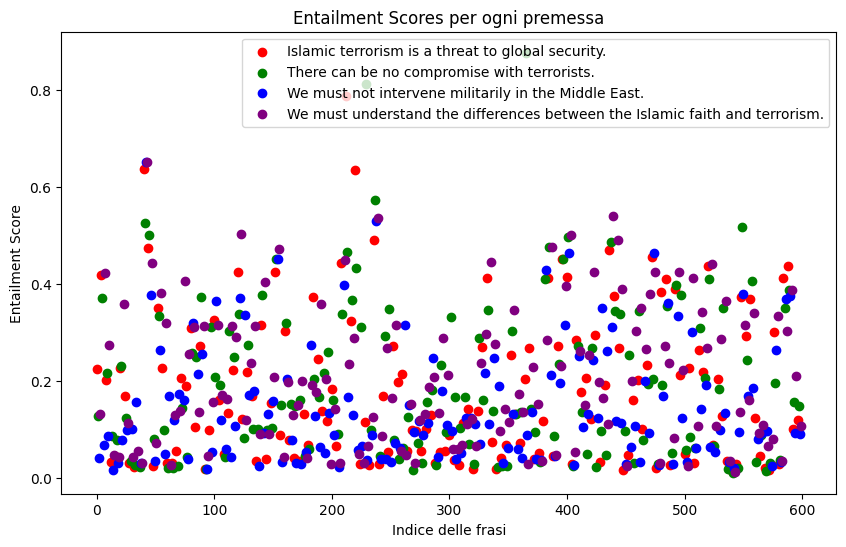

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import util

combined_entailment_scores = test_entailment_scores + validation_entailment_scores
entailment_df = pd.DataFrame({
    'Premesse': premises * len(combined_sentences),
    'Ipotesi': combined_sentences * len(premises),
    'Entailment Score': combined_entailment_scores
})

plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'purple']
x_values = range(len(entailment_df))

for i, premise in enumerate(premises):
    scores = entailment_df[entailment_df['Premesse'] == premise]['Entailment Score']
    plt.scatter([x_values[j] for j in entailment_df.index if entailment_df.iloc[j]['Premesse'] == premise], scores, c=colors[i % len(colors)], label=premise)

plt.xlabel('Indice delle frasi')
plt.ylabel('Entailment Score')
plt.title('Entailment Scores per ogni premessa')
plt.legend()
plt.show()

**RUSSIA: discorso pronunciato da Dmitry Medvedev, segretario generale russo, in occasione di una riunione della Lega Araba del 2009 a cui era stata invitata anche la Russia**

In [ ]:
nlp = spacy.load("en_core_web_sm")

with open('datasetRussia.json', 'r') as file:
    dataset = json.load(file)

validation_data = pd.DataFrame(dataset["validation"])
test_data = pd.DataFrame(dataset["test"])
combined_data = pd.concat([validation_data, test_data])

print(validation_data)
print(test_data)

def preprocess_text(text):
    doc = nlp(text)
    return [sent.text for sent in doc.sents]

sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

test_sentences = [sentence for content in test_data["content"].tolist() for sentence in preprocess_text(content)]
validation_sentences = [sentence for content in validation_data["content"].tolist() for sentence in preprocess_text(content)]
combined_sentences = test_sentences + validation_sentences

print("Le frasi del dataset sono:", combined_sentences)
print("Le frasi della fase di test del modello sono:", test_sentences)
print("Le frasi della fase di validazione del modello sono:", validation_sentences)

doc = nlp(" ".join(combined_data["content"].tolist()))
politici = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
organizzazioni = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
luoghi = [ent.text for ent in doc.ents if ent.label_ == "GPE"]
date = [ent.text for ent in doc.ents if ent.label_ == "DATE"]
eventi = [ent.text for ent in doc.ents if ent.label_ == "EVENT"]

print("Le persone menzionate sono:", politici)
print("Le organizzazioni rilevanti sono:", organizzazioni)
print("I luoghi rilevanti sono:", luoghi)
print("Le date significative:", date)
print("Gli eventi significativi sono:", eventi)

    id                                            content
0   15  It is my conviction that cooperation between R...
1   26  For the first time since the end of the Cold W...
2   20  The initiative we put forward in 2007 to estab...
3   10  Many young people from the Middle East have st...
4    2  This is my first visit to this influential org...
5   21  This settlement should lead to the establishme...
6    6  People here have not forgotten the time when o...
7   14  Russia is an active participant of the Allianc...
8   19  Russia will continue to make strenuous efforts...
9    8  We seek to continue building on these traditio...
10  23  The pause in talks has dragged on for too long...
11  13  Facilitating respectful contact between the me...
12  24  It is essential to ensure that all parties in ...
13  12  I can say quite frankly that Russia has no nee...
14   3  There can be no progress on many of the issues...
    id                                            content
0   29  In con

In [ ]:
prefixed_sentences = [
    "Islamic terrorism is a threat to global security.",
    "There can be no compromise with terrorists.",
    "We must not intervene militarily in the Middle East.",
    "We must understand the differences between the Islamic faith and terrorism."
]

print("Le frasi prefissate sono:")
for prefixed_sentence in prefixed_sentences:
    print(prefixed_sentence)

sentences_embeddings = sentence_transformer.encode(combined_sentences)

prefixed_sentences_embeddings = sentence_transformer.encode(prefixed_sentences)

print("Similarità tra le frasi prefissate e le frasi del dataset")
for i, combined_sentence in enumerate(combined_sentences):
    for j, prefixed_sentence in enumerate(prefixed_sentences):
        similarity = util.pytorch_cos_sim(sentences_embeddings[i], prefixed_sentences_embeddings[j])
        print(f"La similarità tra '{prefixed_sentence}' e '{combined_sentence}' è: {similarity.item():.4f}")

most_similar_sentences = []
for j, prefixed_sentence in enumerate(prefixed_sentences):
    max_similarity = 0
    most_similar_sentence = ""
    for i, combined_sentence in enumerate(combined_sentences):
        similarity = util.pytorch_cos_sim(sentences_embeddings[i], prefixed_sentences_embeddings[j])
        if similarity.item() > max_similarity:
            max_similarity = similarity.item()
            most_similar_sentence = combined_sentence
    most_similar_sentences.append(most_similar_sentence)
    print(f"La frase più simile a '{prefixed_sentence}' è: '{most_similar_sentence}', con similarità pari a {max_similarity:.4f}")

Le frasi prefissate sono:
Islamic terrorism is a threat to global security.
There can be no compromise with terrorists.
We must not intervene militarily in the Middle East.
We must understand the differences between the Islamic faith and terrorism.
Similarità tra le frasi prefissate e le frasi del dataset
La similarità tra 'Islamic terrorism is a threat to global security.' e 'In conclusion, I want to say once again that stronger relations between Russia and the Arab countries are an essential condition for international politics today.' è: 0.4341
La similarità tra 'There can be no compromise with terrorists.' e 'In conclusion, I want to say once again that stronger relations between Russia and the Arab countries are an essential condition for international politics today.' è: 0.2522
La similarità tra 'We must not intervene militarily in the Middle East.' e 'In conclusion, I want to say once again that stronger relations between Russia and the Arab countries are an essential condition 

In [ ]:
model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-large-mnli')
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-large-mnli')

def calculate_entailment_score(premise, hypothesis):
    inputs = tokenizer.encode_plus(premise, hypothesis, add_special_tokens=True, max_length=512, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt')
    outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
    logits = outputs.logits
    entailment_score = torch.sigmoid(logits[:, 2]).item()
    return entailment_score

premises = [
    "Islamic terrorism is a threat to global security.",
    "There can be no compromise with terrorists.",
    "We must not intervene militarily in the Middle East.",
    "We must understand the differences between the Islamic faith and terrorism."
]

hypotheses_test = test_sentences
hypotheses_validation = validation_sentences

def calculate_entailment_scores(sentences, premises):
    entailment_scores = []
    for sentence in sentences:
        for premise in premises:
            entailment_score = calculate_entailment_score(premise, sentence)
            entailment_scores.append(entailment_score)
    return entailment_scores

test_entailment_scores = calculate_entailment_scores(test_sentences, premises)
validation_entailment_scores = calculate_entailment_scores(validation_sentences, premises)

print("Test entailment scores:", test_entailment_scores)
print("Validation entailment scores:", validation_entailment_scores)

test_avg_entailment_score7 = sum(test_entailment_scores) / len(test_entailment_scores)
validation_avg_entailment_score7 = sum(validation_entailment_scores) / len(validation_entailment_scores)

print(f"Test average entailment score: {test_avg_entailment_score7:.4f}")
print(f"Validation average entailment score: {validation_avg_entailment_score7:.4f}")

highest_entailment_sentences = []
for premise in premises:
    max_entailment_score = 0
    highest_entailment_sentence = ""
    for hypothesis in combined_sentences:
        entailment_score = calculate_entailment_score(premise, hypothesis)
        if entailment_score > max_entailment_score:
            max_entailment_score = entailment_score
            highest_entailment_sentence = hypothesis
    highest_entailment_sentences.append(highest_entailment_sentence)
    print(f"La frase con il più alto punteggio di entailment per '{premise}' è '{highest_entailment_sentence}' con un punteggio pari a {max_entailment_score:.4f}")


Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test entailment scores: [0.06789210438728333, 0.17859460413455963, 0.03827524185180664, 0.07496625930070877, 0.04874926060438156, 0.020919732749462128, 0.09746581315994263, 0.03289327770471573, 0.10106496512889862, 0.0398266576230526, 0.12102580070495605, 0.06267669796943665, 0.013051054440438747, 0.02176198735833168, 0.021543407812714577, 0.01978730969130993, 0.1925671398639679, 0.23167338967323303, 0.19827963411808014, 0.21488262712955475, 0.17456673085689545, 0.1312365084886551, 0.09336067736148834, 0.2853163480758667, 0.027671366930007935, 0.026506630703806877, 0.024955524131655693, 0.02857225015759468, 0.05720333382487297, 0.03458484634757042, 0.05238296464085579, 0.05623829364776611, 0.06851203739643097, 0.01767685078084469, 0.0792752131819725, 0.0296312365680933, 0.02110886014997959, 0.01875891163945198, 0.03157353028655052, 0.014961387030780315, 0.08787674456834793, 0.024630025029182434, 0.012380531057715416, 0.042916420847177505, 0.029762903228402138, 0.09212057292461395, 0.06

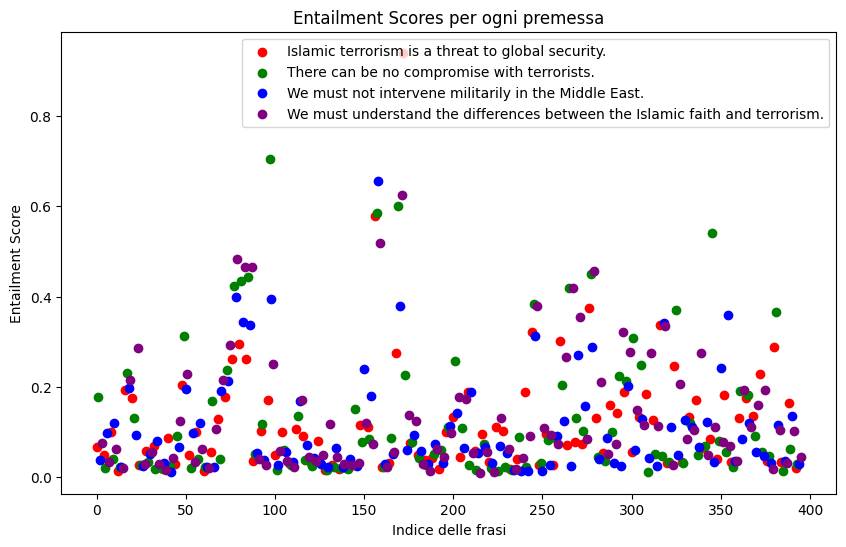

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import util

combined_entailment_scores = test_entailment_scores + validation_entailment_scores
entailment_df = pd.DataFrame({
    'Premesse': premises * len(combined_sentences),
    'Ipotesi': combined_sentences * len(premises),
    'Entailment Score': combined_entailment_scores
})

plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'purple']
x_values = range(len(entailment_df))

for i, premise in enumerate(premises):
    scores = entailment_df[entailment_df['Premesse'] == premise]['Entailment Score']
    plt.scatter([x_values[j] for j in entailment_df.index if entailment_df.iloc[j]['Premesse'] == premise], scores, c=colors[i % len(colors)], label=premise)

plt.xlabel('Indice delle frasi')
plt.ylabel('Entailment Score')
plt.title('Entailment Scores per ogni premessa')
plt.legend()
plt.show()

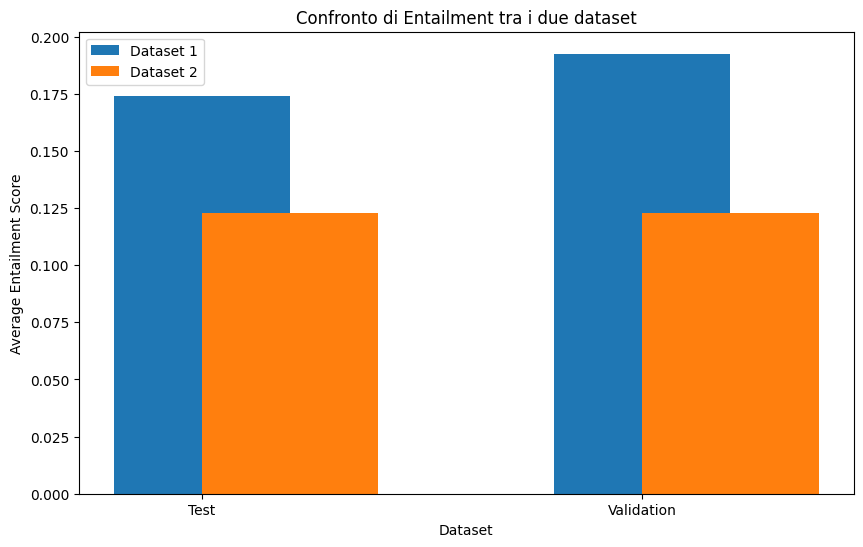

In [ ]:
labels = ['Test', 'Validation']
scores1 = [test_avg_entailment_score6, validation_avg_entailment_score6]
scores2 = [test_avg_entailment_score7, validation_avg_entailment_score7]

x = range(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x, scores1, width=0.4, label='Dataset 1', align='center')
plt.bar(x, scores2, width=0.4, label='Dataset 2', align='edge')
plt.xlabel('Dataset')
plt.ylabel('Average Entailment Score')
plt.title('Confronto di Entailment tra i due dataset')
plt.xticks(x, labels)
plt.legend()
plt.show()